<a href="https://colab.research.google.com/github/amenimtibaa/Movie-Rating-Prediction-with-Matrix-Factorization/blob/master/BSGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***movielens recommendation project : Matrix Factorization with Biased Stochastic Gradient Descent (BSGD)***





In [0]:
%matplotlib inline
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Code of BSGD

### install movielens on colab



In [0]:
!curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip
!cd ml-100k/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0  2462k      0  0:00:01  0:00:01 --:--:-- 2460k
Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test       

### load movielens into a dataframe

In [0]:
names = ['user_id', 'item_id', 'rating','timestamp']
ratings_df = pd.read_csv('ml-100k/u.data', sep='\t', names=names)


### Split database into train and test

In [0]:
train_data = ratings_df.iloc[:int((len(ratings_df))*0.8),:3] # Splits 80% to training set
test_data = ratings_df.iloc[int(len(ratings_df)*0.8):,:3] # Remaining 20% data to test set
ratings_df=train_data

### Function to generate a ratings matrix and mappings for the user and item ids to the row and column indices 

In [0]:
def get_rating_matrix(X):
    """
    Returns
    -------
    rating_matrix : 2d numpy array, shape=(n_users, n_items)
    user_map : pandas Series, shape=(n_users,)
        Mapping from the original user id to an integer in the range [0,n_users)
    item_map : pandas Series, shape=(n_items,)
        Mapping from the original item id to an integer in the range [0,n_items)
    """
    user_col, item_col, rating_col = X.columns[:3]
    rating = X[rating_col]
    user_map = pd.Series(
        index=np.unique(X[user_col]),
        data=np.arange(X[user_col].nunique()),
        name='user_map',
    )
    item_map = pd.Series(
        index=np.unique(X[item_col]),
        data=np.arange(X[item_col].nunique()),
        name='columns_map',
    )
    user_inds = X[user_col].map(user_map)
    item_inds = X[item_col].map(item_map)
    rating_matrix = (
        pd.pivot_table(
            data=X,
            values=rating_col,
            index=user_inds,
            columns=item_inds,
        )
        .fillna(0)
        .values
    )
    return rating_matrix, user_map, item_map


### Inititialize user/item bias

In [0]:
class InitBias():
  def __init__(self, X):
    """
    Init the bias of rating term: 
        b_i,j= mu + b_u + b_i 

    mu : Average rating over all training samples
    b_u :User bias, shape = [n_users]
        
    b_i : Movie bias, shape = [n_movies] 
    """
    X = X.iloc[:, :3].copy()
    X.columns = ['user', 'item', 'rating']
    mu = np.mean(X['rating'])
    user_counts = X['user'].value_counts() #counts of unique values
    movie_counts = X['item'].value_counts()
    b_u = (
        X[['user', 'rating']]
        .groupby('user')['rating']
        .sum()
        .subtract(user_counts * mu)
        .divide(user_counts )
        .rename('b_u')
    )
    X = X.join(b_u, on='user')
    X['item_residual'] = X['rating'] - X['b_u'] - mu
    b_i = (
        X[['item', 'item_residual']]
        .groupby('item')['item_residual']
        .sum()
        .divide(movie_counts )
        .rename('b_i')
    )
    self.b_u = b_u
    self.b_i = b_i
    self.mu=mu
      
  def predict_unkown(self, X):
      """
      Return rating predictions for unkown user or items 
        (solve the cold start problem)
      """
      X = X.iloc[:, :2].copy()
      X.columns = ['user', 'item']
      X = X.join(self.b_u, on='user').fillna(0)
      X = X.join(self.b_i, on='item').fillna(0)
      return (self.mu + X['b_u'] + X['b_i']).values


### Biased stochasitc gradient descent algorithm 

In [0]:
class Biased_SGD():

  def __init__(self, k=5, learning_rate=0.1, max_epochs=15,
                user_reg=0.0, item_reg=0.0, user_bias_reg=0.0, item_bias_reg=0.0):
    """ initialize gradient parameters"""

    #Number of latent features
    self.k = k
    #Speed at which to descend down gradient
    self.learning_rate = learning_rate
    #Max number of iterations to run
    self.max_epochs = max_epochs
    #Regularization parameter for the latent feature weights in U, >=0
    self.user_reg = user_reg
    #Regularization parameter for the latent feature weights in I, >=0
    self.item_reg = item_reg
    #Regularization parameter for the b_u terms, >=0
    self.user_bias_reg = user_bias_reg
    #Regularization parameter for the b_i terms, >=0
    self.item_bias_reg = item_bias_reg
    #User matrix
    self.U = None
    #Item matrix
    self.I = None
    #Current epoch
    self.epoch = 0

  def _calc_train_error(self, U, I, mu, b_u, b_i, R):
    """ compute RMSE error""" 
    R_selector = (R > 0)
    R_hat = np.dot(U, I.T) + mu + b_u[:, None] + b_i[None, :]
    error = np.sqrt(np.sum(R_selector * pow((R_hat - R),2)) / np.sum(R_selector))
    return error

  def _fit_init(self, X):
    """compute the gradient descent parameters"""
    user_col, item_col, rating_col = X.columns[:3]
    self.BiasInit = InitBias(X=X)
    self.b_u, self.b_i, self.mu = self.BiasInit.b_u.values, self.BiasInit.b_i.values, self.BiasInit.mu
    self.R, self.user_map, self.item_map = get_rating_matrix(X)
    n_users, n_items = self.R.shape
    self.U = np.random.normal(scale=1.0/self.k, size=(n_users, self.k))
    self.I = np.random.normal(scale=1.0/self.k, size=(n_items, self.k))
    self.train_errors = []
    self.error=0

  def fit(self, X,n_epochs=1):
    """ Train the gradient descent algorithm """
    X = X.copy()
    X.iloc[:, 0] = X.iloc[:, 0].map(self.user_map)
    X.iloc[:, 1] = X.iloc[:, 1].map(self.item_map)
    for i_epoch in range(n_epochs):
        #Shuffle data
        X = X.sample(frac=1) 
        for row in X.itertuples():
            index, user, item, rating = row[:4]
            #Get the predicted value
            pred = self.predict_1_train(user, item)
            err = pred - self.R[user, item]
            #Update user bias
            self.b_u[user] -= self.learning_rate * (err + self.user_bias_reg * self.b_u[user])
            #Update movie bias
            self.b_i[item] -= self.learning_rate * (err + self.item_bias_reg * self.b_i[item])
            #Update user matrix
            self.U[user, :] -= self.learning_rate * (
                err * self.I[item, :] + self.user_reg * self.U[user, :]
            )
            #Update item matrix
            self.I[item, :] -= self.learning_rate * (
                err * self.U[user, :] + self.item_reg * self.I[item, :]
            )
        #compute the overeall error
        self.error = self._calc_train_error(self.U, self.I, self.mu, self.b_u, self.b_i, self.R)
        self.train_errors.append(self.error)
        self.epoch += 1
    return self

  def predict_1_train(self, user, item):
    """ prediction value for 1 known user/item pair """
    pred = self.mu + self.b_u[user] + self.b_i[item]
    pred += np.dot(self.U[user, :], self.I[item, :])
    return pred

  def predict(self, X):
    """ Generate predictions for the overall user/item pairs """
    X = X.copy()
    user_col, item_col = X.columns[:2]
    #mask to distinguish known users/items and unkown users/items
    known_user_and_item_mask = (
        X[user_col].isin(self.user_map.index) & X[item_col].isin(self.item_map.index)
    )
    #Separate known users/items and unkown users/items
    X_known, X_unknown = X[known_user_and_item_mask], X[~known_user_and_item_mask]
    #Get user indices of known users
    user_inds = X_known[user_col].map(self.user_map)
    #Get item indices of known items
    item_inds = X_known[item_col].map(self.item_map)
    #compute ratings for known users/items
    rating_pred = np.array([
        self.predict_1_train(u_ind, i_ind)
        for u_ind, i_ind in zip(user_inds, item_inds)
    ])
    X.loc[known_user_and_item_mask, 'rating'] = rating_pred
    #compute ratings for unknown users/items
    X.loc[~known_user_and_item_mask, 'rating'] = self.BiasInit.predict_unkown(X_unknown)
    return X['rating'].values

## Hyperparameters Tuning (using 5-fold cross validation)

### Number of epoch

In [0]:
n_splits = 5
max_epochs = 30
k = 20
lr=0.01
reg=0
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
train_errs = np.zeros((n_splits, max_epochs))
test_errs = np.zeros((n_splits, max_epochs))
for i_fold, (train_inds, test_inds) in enumerate(kf.split(ratings_df)):
    print("i_fold={}".format(i_fold))
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    rec = Biased_SGD(k=k, learning_rate=lr, user_reg=reg, item_reg=reg,
                         user_bias_reg=reg, item_bias_reg=reg, max_epochs=max_epochs)
    rec._fit_init(train_df)
    for i_epoch in range(max_epochs):
        rec.fit(train_df, n_epochs=1)
        preds = rec.predict(test_df[['user_id', 'item_id']])
        test_err = np.sqrt(mean_squared_error(preds, test_df['rating']))
        test_errs[i_fold, i_epoch] = test_err
    train_errs[i_fold, :] = np.array(rec.train_errors)

i_fold=0
i_fold=1
i_fold=2
i_fold=3
i_fold=4


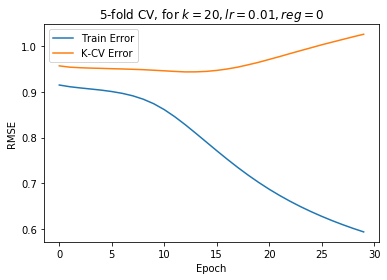

In [0]:
#plot
train_avg, train_std = train_errs.mean(axis=0), train_errs.std(axis=0)
test_avg, test_std = test_errs.mean(axis=0), test_errs.std(axis=0)
plt.plot(np.arange(max_epochs), train_avg, label='Train Error')
plt.plot(np.arange(max_epochs), test_avg, label='K-CV Error')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('5-fold CV, for $k={}, lr= {}, reg={}$'.format(k,lr,reg))
plt.show()

### Number of latent features

In [0]:
n_splits = 5
max_epochs = 12
lr=0.01
reg=0
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
k_list = [1, 5, 10, 20, 50, 90, 120]
train_errs = np.zeros((n_splits, len(k_list)))
test_errs = np.zeros((n_splits, len(k_list)))
for i_fold, (train_inds, test_inds) in enumerate(kf.split(ratings_df)):
    print("i_fold={}: ".format(i_fold), end='')
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    for i_k, k in enumerate(k_list):
        print("k={}, ".format(k), end='')
        rec = Biased_SGD(k=k, learning_rate=lr, user_reg=reg, item_reg=reg,
                         user_bias_reg=reg, item_bias_reg=reg, max_epochs=max_epochs)
        rec._fit_init(train_df)
        rec.fit(train_df, n_epochs=max_epochs)
        preds = rec.predict(test_df[['user_id', 'item_id']])
        test_err = np.sqrt(mean_squared_error(preds, test_df['rating']))
        test_errs[i_fold, i_k] = test_err
        train_errs[i_fold, i_k] = rec.error
    print()
    

i_fold=0: k=1, k=5, k=10, k=20, k=50, k=90, k=120, 
i_fold=1: k=1, k=5, k=10, k=20, k=50, k=90, k=120, 
i_fold=2: k=1, k=5, k=10, k=20, k=50, k=90, k=120, 
i_fold=3: k=1, k=5, k=10, k=20, k=50, k=90, k=120, 
i_fold=4: k=1, k=5, k=10, k=20, k=50, k=90, k=120, 


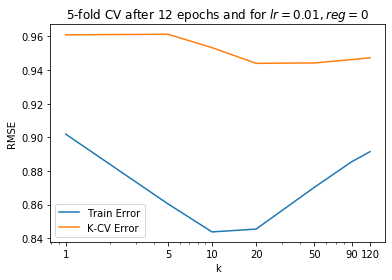

In [0]:
train_avg = train_errs.mean(axis=0)
test_avg = test_errs.mean(axis=0)
plt.semilogx(k_list, train_avg, label='Train Error')
plt.semilogx(k_list, test_avg, label='K-CV Error')
plt.xticks(k_list, k_list)
plt.legend()
plt.xlabel('k')
plt.ylabel('RMSE')
plt.title('5-fold CV after {} epochs and for $lr= {}, reg={}$'.format(max_epochs,lr,reg))
plt.show()

###learning rate


In [0]:
n_splits = 5
max_epochs = 12
k = 50
reg=0
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
learning_rate_list = [0.00001, 0.0001, 0.001, 0.01]
train_errs = np.zeros((n_splits, len(learning_rate_list)))
test_errs = np.zeros((n_splits, len(learning_rate_list)))
for i_fold, (train_inds, test_inds) in enumerate(kf.split(ratings_df)):
    print("i_fold={}: ".format(i_fold), end='')
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    for i_lr, lr in enumerate(learning_rate_list):
        print("lr={}, ".format(lr), end='')
        rec = Biased_SGD(k=k, learning_rate=lr, user_reg=0.0, item_reg=0.0,
                         user_bias_reg=0.0, item_bias_reg=0.0, max_epochs=max_epochs)
        rec._fit_init(train_df)
        rec.fit(train_df, n_epochs=max_epochs)
        preds = rec.predict(test_df[['user_id', 'item_id']])
        test_err = np.sqrt(mean_squared_error(preds, test_df['rating']))
        test_errs[i_fold, i_lr] = test_err
        train_errs[i_fold, i_lr] = rec.error
    print()

i_fold=0: lr=1e-05, lr=0.0001, lr=0.001, lr=0.01, 
i_fold=1: lr=1e-05, lr=0.0001, lr=0.001, lr=0.01, 
i_fold=2: lr=1e-05, lr=0.0001, lr=0.001, lr=0.01, 
i_fold=3: lr=1e-05, lr=0.0001, lr=0.001, lr=0.01, 
i_fold=4: lr=1e-05, lr=0.0001, lr=0.001, lr=0.01, 


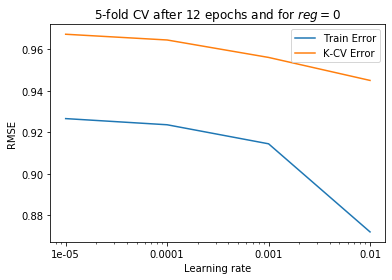

In [0]:
train_avg = train_errs.mean(axis=0)
test_avg = test_errs.mean(axis=0)
plt.semilogx(learning_rate_list, train_avg, label='Train Error')
plt.semilogx(learning_rate_list, test_avg, label='K-CV Error')
plt.xticks(learning_rate_list, learning_rate_list)
plt.legend()
plt.xlabel('Learning rate')
plt.ylabel('RMSE')
plt.title('5-fold CV after {} epochs and for $reg={}$'.format(max_epochs,reg))
plt.show()

###Regularization parameters

In [0]:
n_splits = 4 #5
max_epochs = 12
k = 50
Lr=0.001
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
regularization_list = [0.01, 0.1, 0.2, 0.3, 0.4, 0.7,1]
train_errs = np.zeros((n_splits, len(regularization_list)))
test_errs = np.zeros((n_splits, len(regularization_list)))
for i_fold, (train_inds, test_inds) in enumerate(kf.split(ratings_df)):
    print("i_fold={}: ".format(i_fold), end='')
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    for i_reg, reg in enumerate(regularization_list):
        print("reg={}, ".format(reg), end='')
        rec = Biased_SGD(k=k, learning_rate=lr, user_reg=reg, item_reg=reg,
                         user_bias_reg=0.0, item_bias_reg=0.0, max_epochs=max_epochs)
        rec._fit_init(train_df)
        rec.fit(train_df, n_epochs=max_epochs)
        preds = rec.predict(test_df[['user_id', 'item_id']])
        test_err = np.sqrt(mean_squared_error(preds, test_df['rating']))
        test_errs[i_fold, i_reg] = test_err
        train_errs[i_fold, i_reg] = rec.error
    print()

i_fold=0: reg=0.01, reg=0.1, reg=0.2, reg=0.3, reg=0.4, reg=0.7, reg=1, 
i_fold=1: reg=0.01, reg=0.1, reg=0.2, reg=0.3, reg=0.4, reg=0.7, reg=1, 
i_fold=2: reg=0.01, reg=0.1, reg=0.2, reg=0.3, reg=0.4, reg=0.7, reg=1, 
i_fold=3: reg=0.01, reg=0.1, reg=0.2, reg=0.3, reg=0.4, reg=0.7, reg=1, 


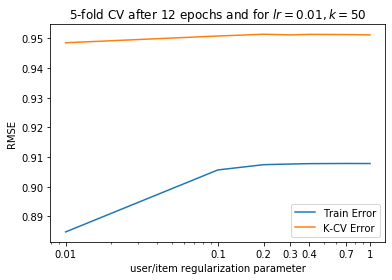

In [0]:
train_avg = train_errs.mean(axis=0)
test_avg = test_errs.mean(axis=0)
plt.semilogx(regularization_list, train_avg, label='Train Error')
plt.semilogx(regularization_list, test_avg, label='K-CV Error')
plt.xticks(regularization_list, regularization_list)
plt.legend()
plt.xlabel('user/item regularization parameter')
plt.ylabel('RMSE')
plt.title('5-fold CV after {} epochs and for $lr= {}, k={}$'.format(max_epochs,lr,k))
plt.show()

###User/item bias


In [0]:
n_splits = 5
max_epochs = 12
k = 50
Lr=0.001
reg= 0.3
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
user_item_bias_list = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4]
train_errs = np.zeros((n_splits, len(user_item_bias_list)))
test_errs = np.zeros((n_splits, len(user_item_bias_list)))
for i_fold, (train_inds, test_inds) in enumerate(kf.split(ratings_df)):
    print("i_fold={}: ".format(i_fold), end='')
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    for i_bias, bias in enumerate(user_item_bias_list):
        print("bias={}, ".format(bias), end='')
        rec = Biased_SGD(k=k, learning_rate=lr, user_reg=reg, item_reg=reg,
                         user_bias_reg=bias, item_bias_reg=bias, max_epochs=max_epochs)
        rec._fit_init(train_df)
        rec.fit(train_df, n_epochs=max_epochs)
        preds = rec.predict(test_df[['user_id', 'item_id']])
        test_err = np.sqrt(mean_squared_error(preds, test_df['rating']))
        test_errs[i_fold, i_bias] = test_err
        train_errs[i_fold, i_bias] = rec.error
    print()

i_fold=0: bias=0.001, bias=0.01, bias=0.1, bias=0.2, bias=0.3, bias=0.4, 
i_fold=1: bias=0.001, bias=0.01, bias=0.1, bias=0.2, bias=0.3, bias=0.4, 
i_fold=2: bias=0.001, bias=0.01, bias=0.1, bias=0.2, bias=0.3, bias=0.4, 
i_fold=3: bias=0.001, bias=0.01, bias=0.1, bias=0.2, bias=0.3, bias=0.4, 
i_fold=4: bias=0.001, bias=0.01, bias=0.1, bias=0.2, bias=0.3, bias=0.4, 


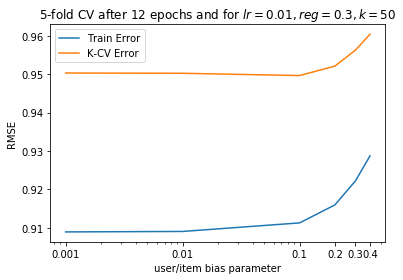

In [0]:
train_avg = train_errs.mean(axis=0)
test_avg = test_errs.mean(axis=0)
plt.semilogx(user_item_bias_list, train_avg, label='Train Error')
plt.semilogx(user_item_bias_list, test_avg, label='K-CV Error')
plt.xticks(user_item_bias_list, user_item_bias_list)
plt.legend()
plt.xlabel('user/item bias parameter')
plt.ylabel('RMSE')
plt.title('5-fold CV after {} epochs and for $lr= {}, reg={}, k= {} $'.format(max_epochs,lr,reg, k))
plt.show()

## Final Test

In [0]:
max_epochs = 12
k = 50
Lr=0.001
reg= 0.3
bias= 0.2
train_errs = np.zeros(max_epochs)
test_errs = np.zeros(max_epochs)
rec = Biased_SGD(k=k, learning_rate=lr, user_reg=reg, item_reg=reg,
                      user_bias_reg=bias, item_bias_reg=bias, max_epochs=max_epochs)
rec._fit_init(ratings_df)
for i_epoch in range(max_epochs):
  #print("i_epoch ={}, ".format(i_epoch), end='')
  rec.fit(ratings_df, n_epochs=max_epochs)
  preds = rec.predict(test_data[['user_id', 'item_id']])
  test_err = np.sqrt(mean_squared_error(preds, test_data['rating']))
  test_errs[i_epoch] = test_err
  train_errs[i_epoch] = rec.error

In [0]:
print('Test error : ', test_err,', Train error : ', rec.error)

Test error :  0.9425145671546351 , Train error :  0.9197783959722362


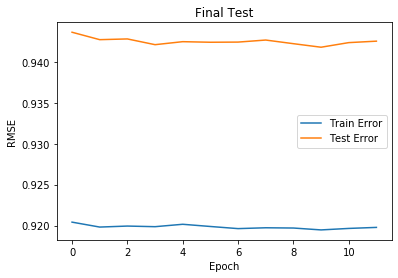

In [0]:
plt.plot(np.arange(max_epochs), train_errs, label='Train Error')
plt.plot(np.arange(max_epochs), test_errs, label='Test Error')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Final Test')
plt.show()